<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import time

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

## Подготовка

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
#Напишем функцию для получения информации о датасете

def status_data(data):

    print(data.head())
    print()
    print('Информация о датасете: ')
    print(data.info())
    print('------------------------')
    print('Количество пропусков в данных')
    print(data.isna().sum())
    print('------------------------')
    print('Количество дупликатов в данных:', data.duplicated().sum())
    print('------------------------')
    print(data.describe())

In [4]:
status_data(df)

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None
------------------------
Количество пропусков в данных
num_orders    0
dtype: int64
------------------------
Количество дупликатов в данных: 26415
------------------------
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В данных нет дубликатов и пропущенных значений. Можно переходить к анализу

In [6]:
#Ресемплируем данные по часу
df = df.resample('1H').sum()

## Анализ

In [7]:
#Напишем функцию для построения графиков анализа данных
def lineplot(data, headline):
    data.plot()
    plt.title(headline)
    plt.show()

Чтобы лучше понимать временной ряд, разделим графики на тренды и сезонность функцией seasonal_decompose

In [8]:
decomposed = seasonal_decompose(df)

In [9]:
sns.set(rc={'figure.figsize':(15,6)})

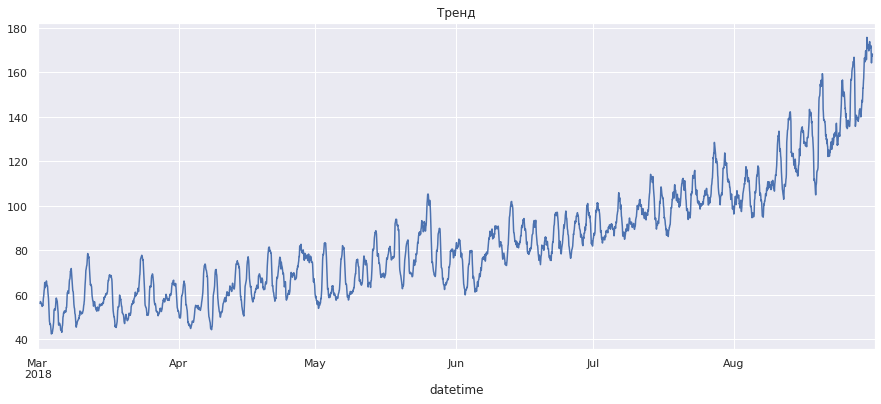

In [10]:
lineplot(decomposed.trend, 'Тренд')

Немноно выровняем тренд с испоьзованеим скользящего среднего для сглаживания временного ряда

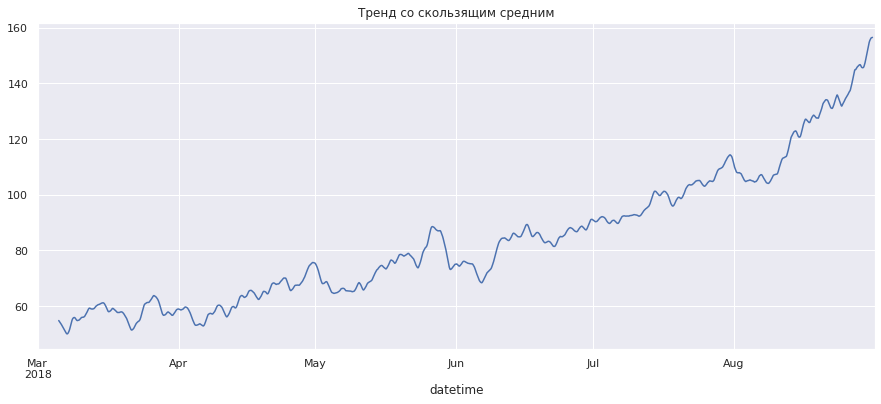

In [11]:
lineplot(decomposed.trend.rolling(100).mean(), 'Тренд со скользящим средним')

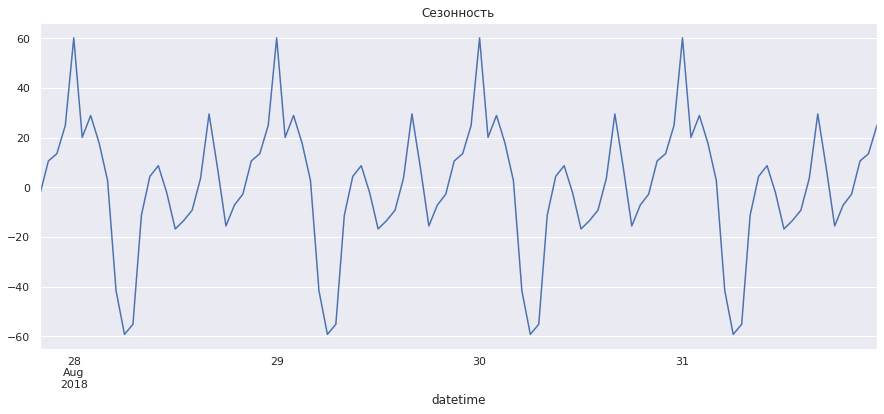

In [12]:
lineplot(decomposed.seasonal.tail(100), 'Сезонность')

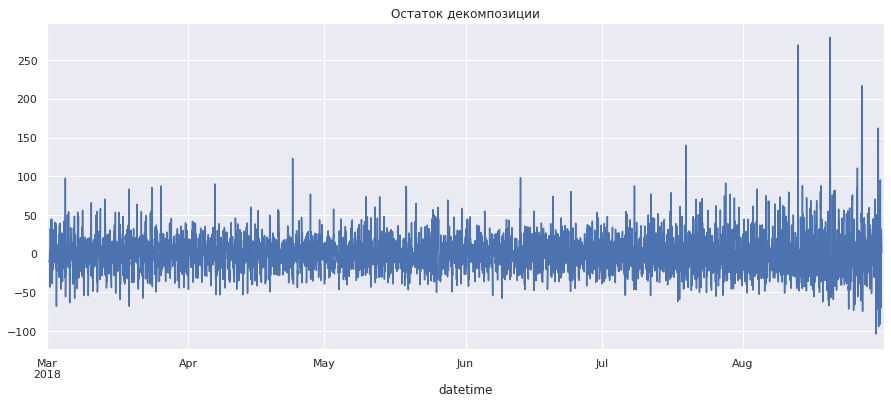

In [13]:
lineplot(decomposed.resid, 'Остаток декомпозиции')

Рассмотрим также признаки для:

- Часа дня
- Дня недели

In [14]:
df_more = df.copy()

In [15]:
df_more['hour'] = df_more.index.hour
df_more['dayofweek'] = df_more.index.dayofweek

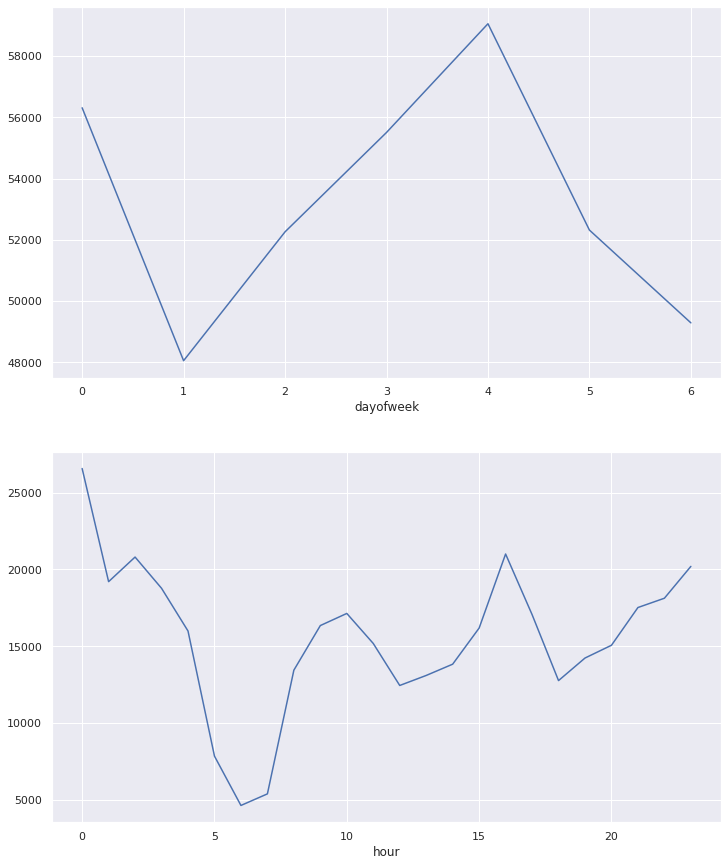

In [16]:
#Построим графики количества заказов
plt.figure(figsize=(12,15))
plt.subplot(2,1,1)
df_more.groupby('dayofweek')['num_orders'].sum().plot();
plt.subplot(2,1,2)
df_more.groupby('hour')['num_orders'].sum().plot();

**Промежуточный вывод анализа данных:**
- График "Тренд" отображает постепенный рост заказов к осени
- Временной ряд - стационарный
- Утром количество заказов резко падает, рост и пик заказов приходится на вечернее время и полночь
- Больше всего заказов приходится на пятницу

## Обучение

In [17]:
# Напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 15, 9)

In [18]:
df.describe()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean
count,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4408.000000,4407.000000,4406.000000,4405.000000,4404.000000,4403.000000,4402.00000,4401.000000,4407.000000
mean,84.422781,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.236162,84.228954,84.217885,84.199319,84.187557,84.168749,84.14448,84.117473,84.320198
std,45.023853,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,44.831888,44.834421,44.833486,44.821634,44.819924,44.807630,44.78377,44.752994,30.263125
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,25.888889
25%,54.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.00000,54.000000,62.555556
50%,78.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.00000,78.000000,79.888889
75%,107.000000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.00000,107.000000,101.111111
max,462.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.00000,462.000000,223.111111


In [19]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Разделение на тренировочную и тестовую выборки
train, test = train_test_split(df, test_size=0.1, shuffle=False)

# Разделение на вариационную и тестовую выборки
train, val = train_test_split(train, test_size=0.2, shuffle=False)

train = train.dropna()

In [21]:
#Определим признаки и целевой признак у обучающей и тестовой выборк
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

features_valid = val.drop(['num_orders'],axis=1)
target_valid = val['num_orders']

In [22]:
#Проверка выборок. Нужно чтобы данные из тестовой выборки не попали в обучающую
print('Обучающая выборка:',val.index.min(), val.index.max())
print('Тестовая выборка:',test.index.min(), test.index.max())

Обучающая выборка: 2018-07-11 11:00:00 2018-08-13 13:00:00
Тестовая выборка: 2018-08-13 14:00:00 2018-08-31 23:00:00


In [23]:
#Проверим размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер валидационной выборки: {} объектов, {} признаков'.format(features_valid.shape[0], features_valid.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 3164 объектов, 18 признаков
Размер валидационной выборки: 795 объектов, 18 признаков
Размер тестовой выборки: 442 объектов, 18 признаков


Обучим модель **Линейная регрессия**

In [24]:
#Создадим список для добавления показателей и названия моделей тестирования
train_models = []

In [25]:
model_lr = LinearRegression()

In [26]:
model_lr.fit(features_train,target_train)
lr_predictions = model_lr.predict(features_valid)
rmse_lr = mse(target_valid, lr_predictions, squared=False)
print('RMSE:', rmse_lr)

RMSE: 40.07626232392417


In [27]:
train_models.append(['LinearRegression', rmse_lr])

Обучим модель **CatBoost**

In [28]:
model_cat = CatBoostRegressor(verbose=False)

In [29]:
%%time
model_cat.fit(features_train, target_train, verbose=False)
cat_predictions = model_cat.predict(features_valid)
rmse_cat = mse(target_valid, cat_predictions, squared=False)
print('RMSE:', rmse_cat)

RMSE: 30.94126243025935
CPU times: user 3.56 s, sys: 176 ms, total: 3.74 s
Wall time: 4.61 s


In [30]:
parameters_cb = {'iterations': [1000],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [1, 3]
              }

tscv = TimeSeriesSplit(n_splits = 4)

model_CBR = CatBoostRegressor(logging_level='Silent')
cb_model = GridSearchCV(estimator = model_CBR, param_grid = parameters_cb,cv = tscv, scoring = 'neg_mean_squared_error', verbose = False)
cb_model.fit(features_train, target_train)
cb_model.best_params_

{'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

In [31]:
cb_tuned = CatBoostRegressor(**cb_model.best_params_, logging_level='Silent').fit(features_train, target_train)

In [32]:
y_pred_cat = cb_tuned.predict(features_valid)

In [33]:
cbr_rmse = np.sqrt(mse(target_valid, y_pred_cat))
print("RMSE: %.2f" % cbr_rmse)

RMSE: 30.90


In [34]:
train_models.append(['CatBoostRegressor', cbr_rmse])

Обучим модель **LightGBM**

In [35]:
model_lgb = LGBMRegressor()

In [36]:
%%time
model_lgb.fit(features_train, target_train, verbose=False)
lgb_predictions = model_lgb.predict(features_valid)
rmse_lgb = mse(target_valid, lgb_predictions, squared=False)
print('RMSE:', rmse_lgb)

RMSE: 31.151738819499577
CPU times: user 4min 44s, sys: 3.76 s, total: 4min 48s
Wall time: 4min 50s


In [37]:
%%time
lgbm_params = {"n_estimators": [100, 200],
               "max_depth": [2, 4, 6]
              }

tscv = TimeSeriesSplit(n_splits = 4)

lgbm_cv_model = GridSearchCV(model_lgb,
                             lgbm_params,
                             cv=tscv,
                             scoring = 'neg_mean_squared_error',
                             verbose=True).fit(features_train, target_train)

lgbm_cv_model.best_params_

Fitting 4 folds for each of 6 candidates, totalling 24 fits
CPU times: user 57min 39s, sys: 44 s, total: 58min 23s
Wall time: 58min 42s


{'max_depth': 4, 'n_estimators': 100}

In [38]:
%%time
lgbm_tuned = LGBMRegressor(**lgbm_cv_model.best_params_).fit(features_train, target_train)

CPU times: user 1min 38s, sys: 1.14 s, total: 1min 39s
Wall time: 1min 40s


In [39]:
%%time
y_pred = lgbm_tuned.predict(features_valid)

CPU times: user 40.7 ms, sys: 0 ns, total: 40.7 ms
Wall time: 10.1 ms


In [40]:
rmse_lgb = np.sqrt(mse(target_valid, y_pred))
print("RMSE: %.2f" % rmse_lgb)

RMSE: 31.21


In [41]:
train_models.append(['LGBMRegressor', rmse_lgb])

**Промежуточный вывод по обучению моделей:**

In [42]:
result_edu = pd.DataFrame(train_models, columns=['model', 'rmse_train'])
display(result_edu.sort_values(by='rmse_train'))

,model,rmse_train
1,CatBoostRegressor,30.902941
2,LGBMRegressor,31.213988
0,LinearRegression,40.076262


- Модели LightGBM и CatBoost на базовых параметрах демонстрируют лучшие значения для метрики RMSE.
- Наименьшее RMSE у улучшеной модели CatBoostRegressor - значит тестировать будем эту модель.

## Тестирование

Обучим CatBoostRegressor, а затем измерим качество на объединении треина и валидации

In [47]:
features_train = features_train.append(features_valid, ignore_index=True)
target_train = target_train.append(target_valid, ignore_index=True)

In [48]:
model_cat_final = CatBoostRegressor(n_estimators = 100,max_depth = 4,random_state = 12214)

In [49]:
%%time
model_cat_final.fit(features_train, target_train, verbose=True)

Learning rate set to 0.34053
0:	learn: 35.9131210	total: 3.07ms	remaining: 304ms
1:	learn: 33.1708259	total: 5.89ms	remaining: 289ms
2:	learn: 30.3504801	total: 8.72ms	remaining: 282ms
3:	learn: 29.1517085	total: 11.6ms	remaining: 278ms
4:	learn: 27.9216461	total: 14.2ms	remaining: 271ms
5:	learn: 27.1399293	total: 17.3ms	remaining: 271ms
6:	learn: 26.6494548	total: 20.3ms	remaining: 270ms
7:	learn: 26.2020908	total: 23.3ms	remaining: 268ms
8:	learn: 25.9065187	total: 26.1ms	remaining: 264ms
9:	learn: 25.5959573	total: 28.8ms	remaining: 260ms
10:	learn: 25.4747541	total: 31.9ms	remaining: 258ms
11:	learn: 25.3364381	total: 34.7ms	remaining: 255ms
12:	learn: 24.7321189	total: 37.1ms	remaining: 248ms
13:	learn: 24.4970998	total: 39.7ms	remaining: 244ms
14:	learn: 24.3109837	total: 42.3ms	remaining: 240ms
15:	learn: 24.1563689	total: 44.9ms	remaining: 236ms
16:	learn: 23.8652468	total: 46.7ms	remaining: 228ms
17:	learn: 23.7092182	total: 48.7ms	remaining: 222ms
18:	learn: 23.4929786	total

In [50]:
final_pred = model_cat_final.predict(features_test)
rmse_cat_final = mse(target_test, final_pred, squared=False)
print('RMSE:', rmse_cat_final)

RMSE: 42.12431101547383


**Вывод:**

- Итоговая метрика RMSE для модели CatBoostRegressor - 42.12431101547383

Это соостветвует качеству финальной метрики